In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
BASE_DIR = r"C:\Users\ASUS\OneDrive\Desktop\reduced_chest_xray"
TRAIN_DIR = r"C:\Users\ASUS\OneDrive\Desktop\reduced_chest_xray\train"
CLASSES = ["NORMAL", "PNEUMONIA"]

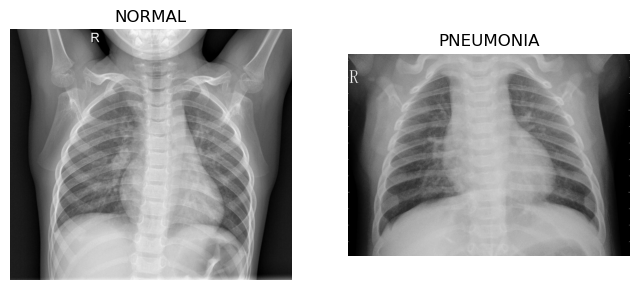

In [4]:
plt.figure(figsize=(8,4))

for i, cls in enumerate(CLASSES):
    cls_path = os.path.join(TRAIN_DIR, cls)
    img_name = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1,2,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")

plt.show()

In [5]:
shapes = []

for cls in CLASSES:
    cls_path = os.path.join(TRAIN_DIR, cls)
    for img_name in os.listdir(cls_path)[:50]:
        img = cv2.imread(os.path.join(cls_path, img_name), cv2.IMREAD_GRAYSCALE)
        shapes.append(img.shape)

shapes = np.array(shapes)

print("Minimum image size:", shapes.min(axis=0))
print("Maximum image size:", shapes.max(axis=0))

Minimum image size: [520 869]
Maximum image size: [1990 2396]


In [6]:
for cls in CLASSES:
    count = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    print(f"{cls} images in training set:", count)

NORMAL images in training set: 900
PNEUMONIA images in training set: 900


In [10]:
IMG_SIZE = 224
def preprocess_images(folder):
    images = []
    labels = []

    for label, cls in enumerate(CLASSES):
        cls_path = os.path.join(folder, cls)

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0   # normalize the image for equal distribution of pixels otherwise not uniform

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [8]:
X_train, y_train = preprocess_images(TRAIN_DIR)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1800, 224, 224)
y_train shape: (1800,)


In [9]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print("CNN input shape:", X_train.shape)

CNN input shape: (1800, 224, 224, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [15]:
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') #can use others too
])

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - accuracy: 0.6221 - loss: 0.6366 - val_accuracy: 0.1472 - val_loss: 0.9322
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 791ms/step - accuracy: 0.8287 - loss: 0.4302 - val_accuracy: 0.8278 - val_loss: 0.4114
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 761ms/step - accuracy: 0.9048 - loss: 0.2660 - val_accuracy: 0.9167 - val_loss: 0.2772
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 761ms/step - accuracy: 0.9364 - loss: 0.1930 - val_accuracy: 0.8083 - val_loss: 0.4533
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 775ms/step - accuracy: 0.9438 - loss: 0.1484 - val_accuracy: 0.9833 - val_loss: 0.0902
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 767ms/step - accuracy: 0.9404 - loss: 0.1759 - val_accuracy: 0.9444 - val_loss: 0.1606
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 774ms/step - accuracy: 0.9584 - loss: 0.1161 - val_accuracy: 0.9389 - val_loss: 0.1525
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 784ms/step - accuracy: 0.9660 - loss: 0.1040 - val_accu

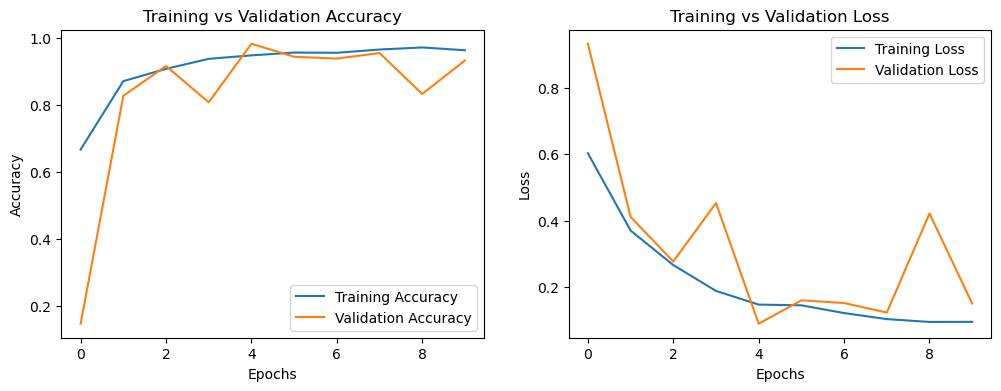

In [23]:
plt.figure(figsize=(12,4))
#Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
#Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

In [24]:
TEST_DIR = r"C:\Users\ASUS\OneDrive\Desktop\reduced_chest_xray\test"
X_test, y_test = preprocess_images(TEST_DIR)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.6949 - loss: 0.6736
Test Accuracy: 0.8125
Test Loss: 0.43126222491264343


In [26]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=CLASSES))

Confusion Matrix:
 [[129 105]
 [ 12 378]]
Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.91      0.55      0.69       234
   PNEUMONIA       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



In [28]:
model.save("pneumonia_cnn_model.h5")
print("Model saved successfully")

Model saved successfully
